# Welcome 

Welcome to the XAI example notebook for TAI4ES 2022 Summer School. Specifcally this is the notebook for `Saliency` methods applied to the SEVIR data. 

### Author
Randy Chase (OU/AI2ES) [email: randychase 'at' ou.edu; twitter: @dopplerchase]

### Purpose
The purpose of this notebook is to provide a code example of running `Saliency` on the neural networks trained to classify if an image contains lightning flashes and how many lightning flashes they contain. 


### How to navigate/run
Check out the table of contents on the left task bar of this image to help you naviate through. 

You should run this notebook from top to bottom. 

If you would like to run this notebook yourself, please select `File` > `Save a copy in Drive` , this will make a copy of this notebook in your Google drive which will let you run and change things

# Setup 

Run the following lines of code to download the datasets needed and install needed packages. We also define a few functions to help with things. 

**Note:** this will take a few minutes to run

In [ ]:
# @title Downloads and installs
%%capture 
#download file
!echo 'Grabbing sub-sevir...'
!gdown 1K-JpG8x7Rlknd_Xc9Y4kmyo9HNXHEasH
!echo 'Done'

!echo 'Grabbing engineered features of sub-sevir...'
!gdown 1NjMnWiGEXpwYF2nGrdASfcFupsXQDCxb
!echo 'Done'

!echo 'Grabbing trained models...'
!gdown 1n3Lf1SfWsMjGgq3DG_k6B7HoiWjRxyVI
!echo 'Done'

#unpack 
!echo 'Unpacking files...'
!tar -xf sub-sevir.tar.gz 
!tar -xf ./sub-sevir/sub-sevir-train.tar.gz -C ./sub-sevir/ 
!tar -xf ./sub-sevir/sub-sevir-val.tar.gz  -C ./sub-sevir/
!tar -xf ./sub-sevir/sub-sevir-test.tar.gz  -C ./sub-sevir/

!tar -xf trained-deep-learning-models.tar.gz 

!tar -xf sub-sevir-engineered.tar.gz 

!echo 'Done'

# install zarr <-- needed to open sub-sevir
!echo 'installing zarr'
!pip -q install zarr 
!echo 'Done'

# !echo 'installing shap'
# !pip install shap
# !echo 'Done'

!echo 'installing saliency'
!pip install saliency
!echo 'Done'

!pip install cmocean

In [ ]:
#@title Define functions
def get_group_idx(group_string,ds):
  return ds.groupby('id').groups[group_string]

def get_groups(ds):
  return list(ds.groupby('id').groups.keys())

def show_sample(ds):
  fig,axes = plt.subplots(1,5,figsize=(15,7.5))
  fig.set_facecolor('w')
  cmaps = ['Blues','turbo','Spectral_r','Greys_r']

  vmins = [-2.5,-2.5,0,0]
  vmaxs = [2,2,20,4]

  for i,ax in enumerate(axes[0:4]):
    ax.imshow(ds.features[:,:,i],cmap=cmaps[i],vmin=vmins[i],vmax=vmaxs[i])
    ax.axis('off')
    ax.set_title(ds.n_channel[i].values)

  ax = axes[4]
  ax.imshow(np.log10(ds.label_2d_reg[:,:]),cmap='magma')
  ax.axis('off')
  ax.set_title('glm')
    
  fig.suptitle('class label: {}, n flashes: {}'.format(ds.label_1d_class.values,ds.label_1d_reg.values),y=0.75)

  return ds.id.values

import numpy as np
import matplotlib.pyplot as plt

turbo_colormap_data = np.array(
                       [[0.18995,0.07176,0.23217],
                       [0.19483,0.08339,0.26149],
                       [0.19956,0.09498,0.29024],
                       [0.20415,0.10652,0.31844],
                       [0.20860,0.11802,0.34607],
                       [0.21291,0.12947,0.37314],
                       [0.21708,0.14087,0.39964],
                       [0.22111,0.15223,0.42558],
                       [0.22500,0.16354,0.45096],
                       [0.22875,0.17481,0.47578],
                       [0.23236,0.18603,0.50004],
                       [0.23582,0.19720,0.52373],
                       [0.23915,0.20833,0.54686],
                       [0.24234,0.21941,0.56942],
                       [0.24539,0.23044,0.59142],
                       [0.24830,0.24143,0.61286],
                       [0.25107,0.25237,0.63374],
                       [0.25369,0.26327,0.65406],
                       [0.25618,0.27412,0.67381],
                       [0.25853,0.28492,0.69300],
                       [0.26074,0.29568,0.71162],
                       [0.26280,0.30639,0.72968],
                       [0.26473,0.31706,0.74718],
                       [0.26652,0.32768,0.76412],
                       [0.26816,0.33825,0.78050],
                       [0.26967,0.34878,0.79631],
                       [0.27103,0.35926,0.81156],
                       [0.27226,0.36970,0.82624],
                       [0.27334,0.38008,0.84037],
                       [0.27429,0.39043,0.85393],
                       [0.27509,0.40072,0.86692],
                       [0.27576,0.41097,0.87936],
                       [0.27628,0.42118,0.89123],
                       [0.27667,0.43134,0.90254],
                       [0.27691,0.44145,0.91328],
                       [0.27701,0.45152,0.92347],
                       [0.27698,0.46153,0.93309],
                       [0.27680,0.47151,0.94214],
                       [0.27648,0.48144,0.95064],
                       [0.27603,0.49132,0.95857],
                       [0.27543,0.50115,0.96594],
                       [0.27469,0.51094,0.97275],
                       [0.27381,0.52069,0.97899],
                       [0.27273,0.53040,0.98461],
                       [0.27106,0.54015,0.98930],
                       [0.26878,0.54995,0.99303],
                       [0.26592,0.55979,0.99583],
                       [0.26252,0.56967,0.99773],
                       [0.25862,0.57958,0.99876],
                       [0.25425,0.58950,0.99896],
                       [0.24946,0.59943,0.99835],
                       [0.24427,0.60937,0.99697],
                       [0.23874,0.61931,0.99485],
                       [0.23288,0.62923,0.99202],
                       [0.22676,0.63913,0.98851],
                       [0.22039,0.64901,0.98436],
                       [0.21382,0.65886,0.97959],
                       [0.20708,0.66866,0.97423],
                       [0.20021,0.67842,0.96833],
                       [0.19326,0.68812,0.96190],
                       [0.18625,0.69775,0.95498],
                       [0.17923,0.70732,0.94761],
                       [0.17223,0.71680,0.93981],
                       [0.16529,0.72620,0.93161],
                       [0.15844,0.73551,0.92305],
                       [0.15173,0.74472,0.91416],
                       [0.14519,0.75381,0.90496],
                       [0.13886,0.76279,0.89550],
                       [0.13278,0.77165,0.88580],
                       [0.12698,0.78037,0.87590],
                       [0.12151,0.78896,0.86581],
                       [0.11639,0.79740,0.85559],
                       [0.11167,0.80569,0.84525],
                       [0.10738,0.81381,0.83484],
                       [0.10357,0.82177,0.82437],
                       [0.10026,0.82955,0.81389],
                       [0.09750,0.83714,0.80342],
                       [0.09532,0.84455,0.79299],
                       [0.09377,0.85175,0.78264],
                       [0.09287,0.85875,0.77240],
                       [0.09267,0.86554,0.76230],
                       [0.09320,0.87211,0.75237],
                       [0.09451,0.87844,0.74265],
                       [0.09662,0.88454,0.73316],
                       [0.09958,0.89040,0.72393],
                       [0.10342,0.89600,0.71500],
                       [0.10815,0.90142,0.70599],
                       [0.11374,0.90673,0.69651],
                       [0.12014,0.91193,0.68660],
                       [0.12733,0.91701,0.67627],
                       [0.13526,0.92197,0.66556],
                       [0.14391,0.92680,0.65448],
                       [0.15323,0.93151,0.64308],
                       [0.16319,0.93609,0.63137],
                       [0.17377,0.94053,0.61938],
                       [0.18491,0.94484,0.60713],
                       [0.19659,0.94901,0.59466],
                       [0.20877,0.95304,0.58199],
                       [0.22142,0.95692,0.56914],
                       [0.23449,0.96065,0.55614],
                       [0.24797,0.96423,0.54303],
                       [0.26180,0.96765,0.52981],
                       [0.27597,0.97092,0.51653],
                       [0.29042,0.97403,0.50321],
                       [0.30513,0.97697,0.48987],
                       [0.32006,0.97974,0.47654],
                       [0.33517,0.98234,0.46325],
                       [0.35043,0.98477,0.45002],
                       [0.36581,0.98702,0.43688],
                       [0.38127,0.98909,0.42386],
                       [0.39678,0.99098,0.41098],
                       [0.41229,0.99268,0.39826],
                       [0.42778,0.99419,0.38575],
                       [0.44321,0.99551,0.37345],
                       [0.45854,0.99663,0.36140],
                       [0.47375,0.99755,0.34963],
                       [0.48879,0.99828,0.33816],
                       [0.50362,0.99879,0.32701],
                       [0.51822,0.99910,0.31622],
                       [0.53255,0.99919,0.30581],
                       [0.54658,0.99907,0.29581],
                       [0.56026,0.99873,0.28623],
                       [0.57357,0.99817,0.27712],
                       [0.58646,0.99739,0.26849],
                       [0.59891,0.99638,0.26038],
                       [0.61088,0.99514,0.25280],
                       [0.62233,0.99366,0.24579],
                       [0.63323,0.99195,0.23937],
                       [0.64362,0.98999,0.23356],
                       [0.65394,0.98775,0.22835],
                       [0.66428,0.98524,0.22370],
                       [0.67462,0.98246,0.21960],
                       [0.68494,0.97941,0.21602],
                       [0.69525,0.97610,0.21294],
                       [0.70553,0.97255,0.21032],
                       [0.71577,0.96875,0.20815],
                       [0.72596,0.96470,0.20640],
                       [0.73610,0.96043,0.20504],
                       [0.74617,0.95593,0.20406],
                       [0.75617,0.95121,0.20343],
                       [0.76608,0.94627,0.20311],
                       [0.77591,0.94113,0.20310],
                       [0.78563,0.93579,0.20336],
                       [0.79524,0.93025,0.20386],
                       [0.80473,0.92452,0.20459],
                       [0.81410,0.91861,0.20552],
                       [0.82333,0.91253,0.20663],
                       [0.83241,0.90627,0.20788],
                       [0.84133,0.89986,0.20926],
                       [0.85010,0.89328,0.21074],
                       [0.85868,0.88655,0.21230],
                       [0.86709,0.87968,0.21391],
                       [0.87530,0.87267,0.21555],
                       [0.88331,0.86553,0.21719],
                       [0.89112,0.85826,0.21880],
                       [0.89870,0.85087,0.22038],
                       [0.90605,0.84337,0.22188],
                       [0.91317,0.83576,0.22328],
                       [0.92004,0.82806,0.22456],
                       [0.92666,0.82025,0.22570],
                       [0.93301,0.81236,0.22667],
                       [0.93909,0.80439,0.22744],
                       [0.94489,0.79634,0.22800],
                       [0.95039,0.78823,0.22831],
                       [0.95560,0.78005,0.22836],
                       [0.96049,0.77181,0.22811],
                       [0.96507,0.76352,0.22754],
                       [0.96931,0.75519,0.22663],
                       [0.97323,0.74682,0.22536],
                       [0.97679,0.73842,0.22369],
                       [0.98000,0.73000,0.22161],
                       [0.98289,0.72140,0.21918],
                       [0.98549,0.71250,0.21650],
                       [0.98781,0.70330,0.21358],
                       [0.98986,0.69382,0.21043],
                       [0.99163,0.68408,0.20706],
                       [0.99314,0.67408,0.20348],
                       [0.99438,0.66386,0.19971],
                       [0.99535,0.65341,0.19577],
                       [0.99607,0.64277,0.19165],
                       [0.99654,0.63193,0.18738],
                       [0.99675,0.62093,0.18297],
                       [0.99672,0.60977,0.17842],
                       [0.99644,0.59846,0.17376],
                       [0.99593,0.58703,0.16899],
                       [0.99517,0.57549,0.16412],
                       [0.99419,0.56386,0.15918],
                       [0.99297,0.55214,0.15417],
                       [0.99153,0.54036,0.14910],
                       [0.98987,0.52854,0.14398],
                       [0.98799,0.51667,0.13883],
                       [0.98590,0.50479,0.13367],
                       [0.98360,0.49291,0.12849],
                       [0.98108,0.48104,0.12332],
                       [0.97837,0.46920,0.11817],
                       [0.97545,0.45740,0.11305],
                       [0.97234,0.44565,0.10797],
                       [0.96904,0.43399,0.10294],
                       [0.96555,0.42241,0.09798],
                       [0.96187,0.41093,0.09310],
                       [0.95801,0.39958,0.08831],
                       [0.95398,0.38836,0.08362],
                       [0.94977,0.37729,0.07905],
                       [0.94538,0.36638,0.07461],
                       [0.94084,0.35566,0.07031],
                       [0.93612,0.34513,0.06616],
                       [0.93125,0.33482,0.06218],
                       [0.92623,0.32473,0.05837],
                       [0.92105,0.31489,0.05475],
                       [0.91572,0.30530,0.05134],
                       [0.91024,0.29599,0.04814],
                       [0.90463,0.28696,0.04516],
                       [0.89888,0.27824,0.04243],
                       [0.89298,0.26981,0.03993],
                       [0.88691,0.26152,0.03753],
                       [0.88066,0.25334,0.03521],
                       [0.87422,0.24526,0.03297],
                       [0.86760,0.23730,0.03082],
                       [0.86079,0.22945,0.02875],
                       [0.85380,0.22170,0.02677],
                       [0.84662,0.21407,0.02487],
                       [0.83926,0.20654,0.02305],
                       [0.83172,0.19912,0.02131],
                       [0.82399,0.19182,0.01966],
                       [0.81608,0.18462,0.01809],
                       [0.80799,0.17753,0.01660],
                       [0.79971,0.17055,0.01520],
                       [0.79125,0.16368,0.01387],
                       [0.78260,0.15693,0.01264],
                       [0.77377,0.15028,0.01148],
                       [0.76476,0.14374,0.01041],
                       [0.75556,0.13731,0.00942],
                       [0.74617,0.13098,0.00851],
                       [0.73661,0.12477,0.00769],
                       [0.72686,0.11867,0.00695],
                       [0.71692,0.11268,0.00629],
                       [0.70680,0.10680,0.00571],
                       [0.69650,0.10102,0.00522],
                       [0.68602,0.09536,0.00481],
                       [0.67535,0.08980,0.00449],
                       [0.66449,0.08436,0.00424],
                       [0.65345,0.07902,0.00408],
                       [0.64223,0.07380,0.00401],
                       [0.63082,0.06868,0.00401],
                       [0.61923,0.06367,0.00410],
                       [0.60746,0.05878,0.00427],
                       [0.59550,0.05399,0.00453],
                       [0.58336,0.04931,0.00486],
                       [0.57103,0.04474,0.00529],
                       [0.55852,0.04028,0.00579],
                       [0.54583,0.03593,0.00638],
                       [0.53295,0.03169,0.00705],
                       [0.51989,0.02756,0.00780],
                       [0.50664,0.02354,0.00863],
                       [0.49321,0.01963,0.00955],
                       [0.47960,0.01583,0.01055]])




def RGBToPyCmap(rgbdata):
    nsteps = rgbdata.shape[0]
    stepaxis = np.linspace(0, 1, nsteps)

    rdata=[]; gdata=[]; bdata=[]
    for istep in range(nsteps):
        r = rgbdata[istep,0]
        g = rgbdata[istep,1]
        b = rgbdata[istep,2]
        rdata.append((stepaxis[istep], r, r))
        gdata.append((stepaxis[istep], g, g))
        bdata.append((stepaxis[istep], b, b))

    mpl_data = {'red':   rdata,
                 'green': gdata,
                 'blue':  bdata}

    return mpl_data


mpl_data = RGBToPyCmap(turbo_colormap_data)
plt.register_cmap(name='turbo', data=mpl_data, lut=turbo_colormap_data.shape[0])

mpl_data_r = RGBToPyCmap(turbo_colormap_data[::-1,:])
plt.register_cmap(name='turbo_r', data=mpl_data_r, lut=turbo_colormap_data.shape[0])


#import custom metrics 
import sys
sys.path.insert(1, '/Users/randyjc2/PythonWorkspace/metrics/')
from custom_metrics import *

#log the metrics so tensorflow can find them 
custom_objects = {'ConditionalMeanAbsoluteError': ConditionalMeanAbsoluteError,
                    'ConditionalMeanError': ConditionalMeanError,
                    'ConditionalRootMeanSquaredError':ConditionalRootMeanSquaredError,
                    'MeanError': MeanError,
                    'MaxCriticalSuccessIndex':MaxCriticalSuccessIndex}

class_idx_str = 'class_idx_str'
call_model_args = {class_idx_str: 0}
def call_model_function_class(images, call_model_args=None, expected_keys='INPUT_OUTPUT_GRADIENTS'):
    target_class_idx =  call_model_args[class_idx_str]
    images = tf.convert_to_tensor(images)
    with tf.GradientTape() as tape:
        if expected_keys==[saliency.base.INPUT_OUTPUT_GRADIENTS]:
            tape.watch(images)
            _, output_layer = model_class(images)
            output_layer = output_layer[:,target_class_idx]
            gradients = np.array(tape.gradient(output_layer, images))
            return {saliency.base.INPUT_OUTPUT_GRADIENTS: gradients}
        else:
            conv_layer, output_layer = model_class(images)
            gradients = np.array(tape.gradient(output_layer, conv_layer))
            return {saliency.base.CONVOLUTION_LAYER_VALUES: conv_layer,
                    saliency.base.CONVOLUTION_OUTPUT_GRADIENTS: gradients}

def call_model_function_reg(images, call_model_args=None, expected_keys=None):
    target_class_idx =  call_model_args[class_idx_str]
    images = tf.convert_to_tensor(images)
    with tf.GradientTape() as tape:
        if expected_keys==[saliency.base.INPUT_OUTPUT_GRADIENTS]:
            tape.watch(images)
            _, output_layer = model_reg(images)
            output_layer = output_layer[:,target_class_idx]
            gradients = np.array(tape.gradient(output_layer, images))
            return {saliency.base.INPUT_OUTPUT_GRADIENTS: gradients}
        else:
            conv_layer, output_layer = model_reg(images)
            gradients = np.array(tape.gradient(output_layer, conv_layer))
            return {saliency.base.CONVOLUTION_LAYER_VALUES: conv_layer,
                    saliency.base.CONVOLUTION_OUTPUT_GRADIENTS: gradients}

%config InlineBackend.figure_format = 'retina'
import copy
def minmax(X):
  X_new = copy.deepcopy(X)
  for i in np.arange(0,4):
    X_new[:,:,i] = (X_new[:,:,i] - np.min(X_new[:,:,i])) / (np.max(X_new[:,:,i]) - np.min(X_new[:,:,i]))
  return X_new

def standardanom(X):
  X_new = copy.deepcopy(X)
  for i in np.arange(0,4):
    X_new[:,:,i] = (X_new[:,:,i] - np.mean(X_new[:,:,i])) / np.std(X_new[:,:,i])
  return X_new

import cmocean
def make_plot(image,mask=None,maskalpha=0.7,title=None,
              cmap=cmocean.cm.balance,normalize=True):

  fig,axes = plt.subplots(2,4)

  fig.set_facecolor('w')

  titles = ['WV','IR','VIL','VIS']
  vmins = [-2.5,-2.5,0,0]
  vmaxs = [2,2,20,4]

  axes_top = axes[0,:]

  cmaps = ['Blues','turbo','Spectral_r','Greys_r']
  for i,ax in enumerate(axes_top):
    ax.imshow(im[:,:,i],cmap=cmaps[i],vmin=vmins[i],vmax=vmaxs[i])
    ax.axis('off')
    ax.set_title(titles[i])

  axes_bottom = axes[1,:]

  if normalize:
    mask = standardanom(mask)
  for i,ax in enumerate(axes_bottom):
    # ax.imshow(im[:,:,i],cmap=cmaps[i],vmin=vmins[i],vmax=vmaxs[i])
    if mask is not None:
      if mask.shape[-1] == 4:
        
        pm= ax.imshow(mask[:,:,i],cmap=cmap,alpha=maskalpha,vmin=-4,vmax=4)
      else:
        pm= ax.imshow(mask,cmap=cmap,alpha=maskalpha)

    ax.axis('off')
    
    
  if title is not None:
    fig.suptitle(title,y=1)
  plt.tight_layout()

  return ax,mask

import copy
def minmax(X):
  X_new = copy.deepcopy(X)
  for i in np.arange(0,4):
    X_new[:,:,i] = (X_new[:,:,i] - np.min(X_new[:,:,i])) / (np.max(X_new[:,:,i]) - np.min(X_new[:,:,i]))
  return X_new

def standardanom(X,axis=True):
  X_new = copy.deepcopy(X)
  if (X_new.shape[-1] == 4) and (axis):
    for i in np.arange(0,4):
      X_new[:,:,i] = (X_new[:,:,i] - np.mean(X_new[:,:,i])) / np.std(X_new[:,:,i])
  elif (X_new.shape[-1] == 4):
      mu = np.mean(X_new)
      sigma = np.std(X_new)
      X_new = (X_new - mu) / sigma
  else:
    X_new = (X_new - np.mean(X_new)) / np.std(X_new)

  return X_new

import cmocean
def make_plot(image,mask=None,maskalpha=0.7,title=None,
              cmap=cmocean.cm.balance,normalize=True):

  fig,axes = plt.subplots(3,4)

  fig.set_facecolor('w')

  titles = ['WV','IR','VIL','VIS']
  vmins = [-2.5,-2.5,0,0]
  vmaxs = [2,2,20,4]

  axes_top = axes[0,:]

  cmaps = ['Blues','turbo','Spectral_r','Greys_r']
  for i,ax in enumerate(axes_top):
    ax.imshow(im[:,:,i],cmap=cmaps[i],vmin=vmins[i],vmax=vmaxs[i])
    ax.axis('off')
    ax.set_title(titles[i])

  axes_middle = axes[1,:]

  if normalize:
    mask_orig = copy.deepcopy(mask)
    mask = standardanom(mask)
  for i,ax in enumerate(axes_middle):
    # ax.imshow(im[:,:,i],cmap=cmaps[i],vmin=vmins[i],vmax=vmaxs[i])
    if mask is not None:
      if mask.shape[-1] == 4:
        
        pm= ax.imshow(mask[:,:,i],cmap=cmap,alpha=maskalpha,vmin=-4,vmax=4)
      else:
        pm= ax.imshow(mask,cmap=cmap,alpha=maskalpha)

    ax.axis('off')
    # plt.colorbar(pm,ax=ax)

  axes_bottom = axes[2,:]

  if normalize:
    mask = standardanom(mask_orig,axis=False)
  for i,ax in enumerate(axes_bottom):
    # ax.imshow(im[:,:,i],cmap=cmaps[i],vmin=vmins[i],vmax=vmaxs[i])
    if mask is not None:
      if mask.shape[-1] == 4:
        pm= ax.imshow(mask[:,:,i],cmap=cmap,alpha=maskalpha,vmin=-4,vmax=4)
      else:
        pm= ax.imshow(mask,cmap=cmap,alpha=maskalpha)

    ax.axis('off')
    # plt.colorbar(pm,ax=ax)
    
  if title is not None:
    fig.suptitle(title,y=1)
  plt.tight_layout()

  return ax,mask

# ML Task overview

The machine learning models here are trained as part of a paper that is in prep for WAF (Chase et al. "A Machine Learning Tutorial for Operational Meteorology, Part II: Neural Networks").

The sub-SEVIR data was used to solve the following two tasks:

(1) Does this image contain a thunderstorm?  
(2) How many lightning flashes are in this image? 

To be explicit, we assume the GOES Lightning Mapper (GLM) observations are unavailable and we need to use the other measurements (e.g., infrared brightness temperature) as features to estimate if there are lightning flashes (i.e., classification), and how many of them are there (i.e., regression).

These are the same tasks as [Chase et al. (2022)](https://arxiv.org/abs/2204.07492), so see that paper if you want perspective. We also discussed these ideas on slide 33 - 37 in the Day 2 slides. 

# Main Code Section

### 1). Load data

We will load in the `sub-SEVIR` dataset here and plot an example image. 

The example image is a strong convective event with plenty of lightning.

/usr/local/lib/python3.7/dist-packages/xarray/core/computation.py:733: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


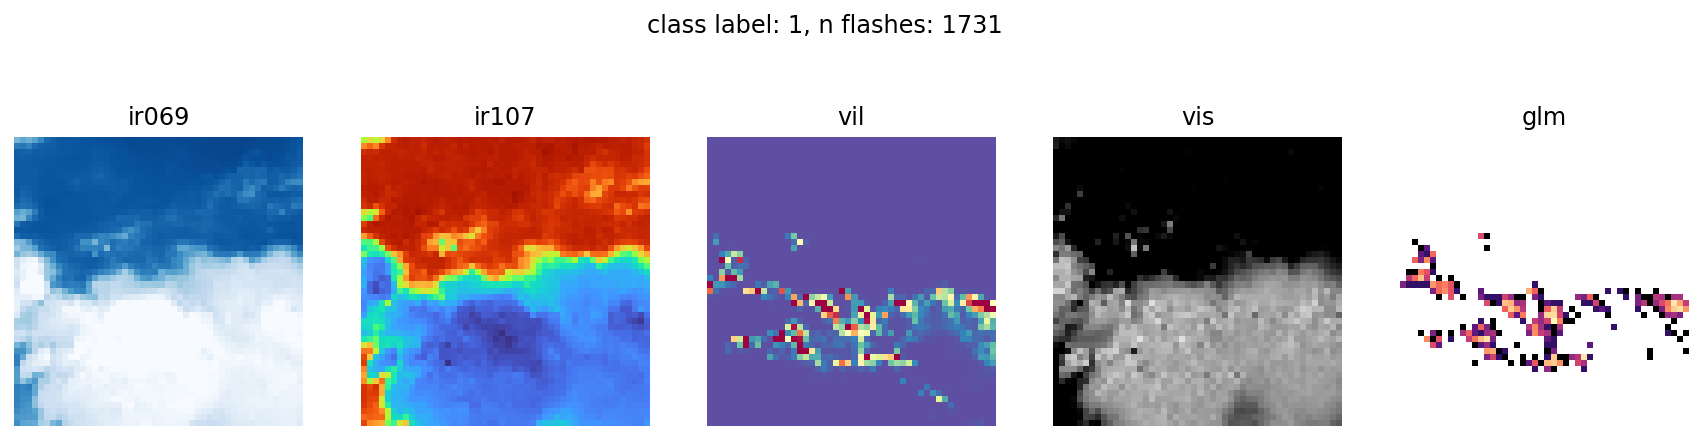

In [ ]:
import xarray as xr 
import matplotlib.pyplot as plt 
import numpy as np
import pandas as pd 

%config InlineBackend.figure_format = 'retina'

ds_train = xr.open_dataset('./sub-sevir/sub-sevir-train.zarr',engine='zarr')
ds_val = xr.open_dataset('./sub-sevir/sub-sevir-val.zarr',engine='zarr')
ds_test = xr.open_dataset('./sub-sevir/sub-sevir-test.zarr',engine='zarr')

#choose 1 'storm' to show in examples
ds_sample = ds_val.isel(n_samples=ds_val.groupby('id').groups['S841009'])

show_sample(ds_sample.isel(n_samples=11))

#store this image to do the XAI on 
im = ds_sample.isel(n_samples=11).features.values 

### 2). Load models

Now that we have some data, let's load in the pretrained CNNs.



In [ ]:
import tensorflow as tf 

#load classification model 
cnn_class= tf.keras.models.load_model('sub-sevir-cnn-class-1d.h5',
                                                 custom_objects=custom_objects)

#XAI wants to see the true loss, not the sigmoid(loss), so we need to remove the 
#sigmoid that is built in the model  
cnn_class.layers[-1].activation = tf.keras.activations.linear

#we also need to see the output of the last convolutional layer
conv_layer = cnn_class.get_layer('conv2d_1')

#link it up 
model_class = tf.keras.models.Model([cnn_class.inputs], [conv_layer.output, cnn_class.output])


#load regression model 
cnn_reg= tf.keras.models.load_model('sub-sevir-cnn-reg-1d.h5',
                                                 custom_objects=custom_objects)

#we also need to see the output of the last convolutional layer
conv_layer = cnn_reg.get_layer('conv2d_1')

#link it up 
model_reg = tf.keras.models.Model([cnn_reg.inputs], [conv_layer.output, cnn_reg.output])

### 3). Saliency (Gradient)



#### a. Strong Convection Example


Before we jump into the XAI, lets see the model predictions

In [ ]:
_,pred_class = model_class(im[np.newaxis,:,:,:])
_,pred_reg = model_reg(im[np.newaxis,:,:,:])
print('Classification output: {}'.format(str(np.round(tf.sigmoid(pred_class[0][0]),3))))
print('Regression output: {} flashes'.format(pred_reg[0][0]))

Classification output: 0.998
Regression output: 761.3433227539062 flashes


So for this example, the classification model is confident there is lightning, and the regression shows more than 700 flashes, note that there actually was 1700 flashes 

##### i. Classification

In [ ]:
# From our repository.
import saliency.core as saliency

# Construct the saliency object. This alone doesn't do anthing.
gradient_saliency = saliency.GradientSaliency()

# Compute the vanilla mask and the smoothed mask.
saliency_map = gradient_saliency.GetMask(im, call_model_function_class, call_model_args)
smooth_saliency = gradient_saliency.GetSmoothedMask(im, call_model_function_class, call_model_args,
                                                       nsamples=1000)

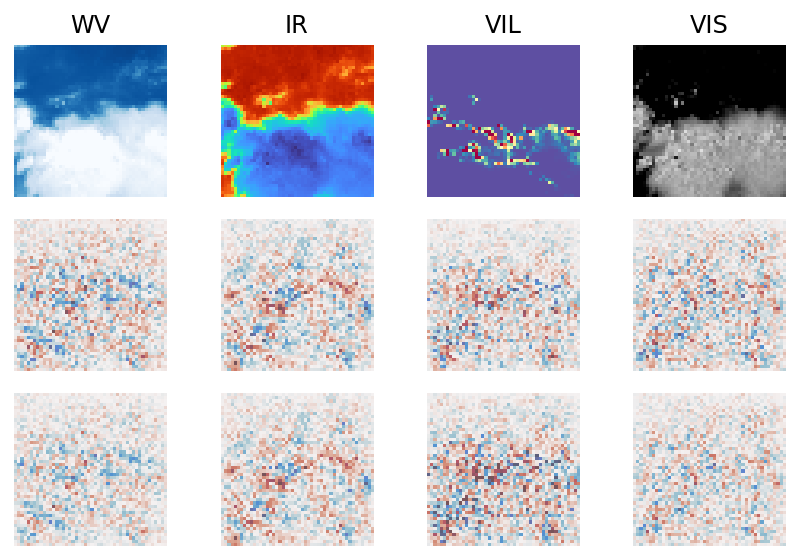

In [ ]:
#Plot the saliency 
ax,m = make_plot(im,mask=saliency_map)

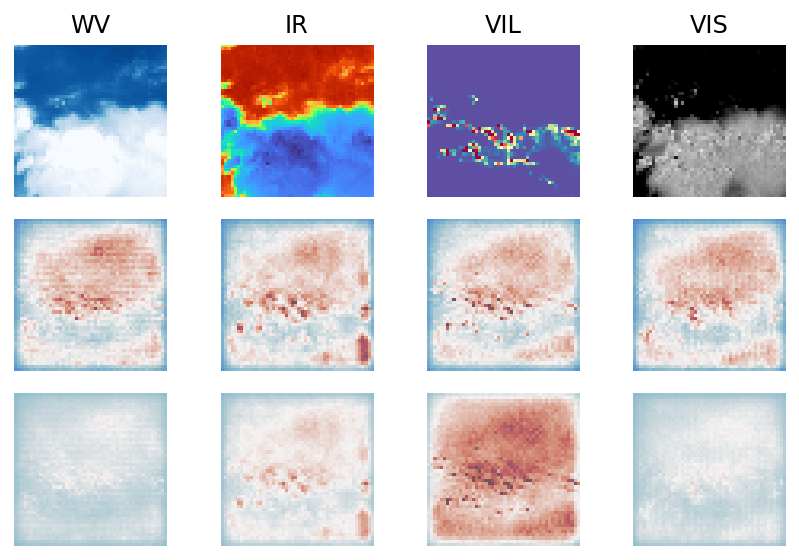

In [ ]:
#Plot the smooth saliency 
ax,m = make_plot(im,mask=smooth_saliency)

The `make_plot` function plots the original image on the top row, and then a transulcent version of the saliency values overtop a greyscaled version of the original image on the bottom row. The brighter the color on the bottom row implies the more 'sensative' thos pixels are to the end prediction.  

We can see here, that the saliency identifies the edges of the cloud boundary as a sensative region to this prediction, but the signal is quite noisey.

##### ii. Regression

In [ ]:
# Construct the saliency object. This alone doesn't do anthing.
gradient_saliency = saliency.GradientSaliency()

# Compute the vanilla mask and the smoothed mask.
saliency_map = gradient_saliency.GetMask(im, call_model_function_reg, call_model_args)
smooth_saliency = gradient_saliency.GetSmoothedMask(im, call_model_function_reg, call_model_args,
                                                       nsamples=1000)

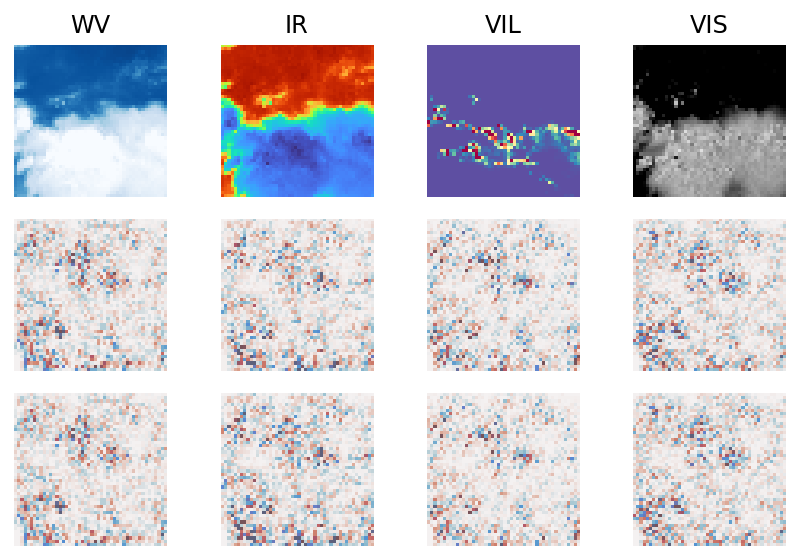

In [ ]:
#Plot the saliency 
ax,m = make_plot(im,mask=saliency_map)

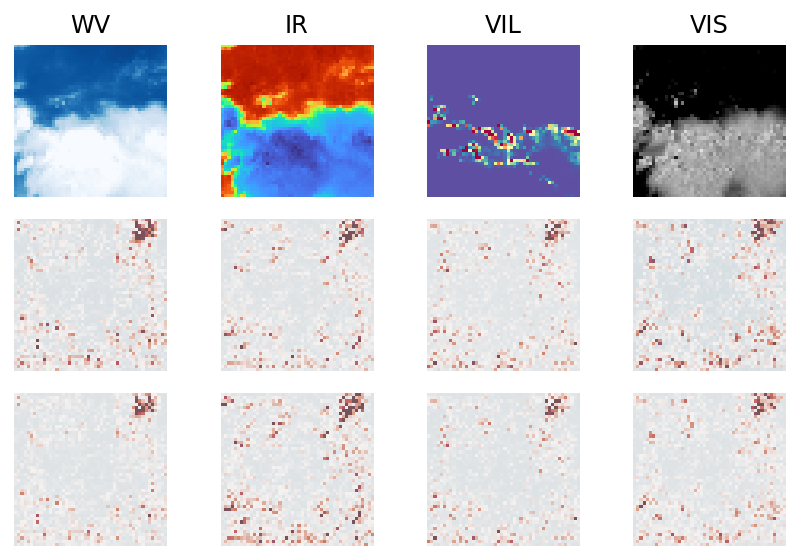

In [ ]:
#Plot the smooth saliency 
ax,m = make_plot(im,mask=smooth_saliency)

The results of the regression dont seem to have any sort of systematic location. 

This highlights one major drawback of saleincy methods, they only indentify parts of the image that are 'sensative' to the prediction. In other words, if these areas of the image changed value, it would change the prediction value. 

This method DOES NOT tell you "this region of the image lead to this much of the prediction". That question is better suited for Shap. 

#### b. No Storm Example

/usr/local/lib/python3.7/dist-packages/xarray/core/computation.py:733: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)
/usr/local/lib/python3.7/dist-packages/matplotlib/image.py:452: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/usr/local/lib/python3.7/dist-packages/matplotlib/image.py:459: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/usr/local/lib/python3.7/dist-packages/matplotlib/image.py:464: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
<string>:6: UserWarning: Warning: converting a masked element to nan.
/usr/local/lib/python3.7/dist-packages/matplotlib/colors.py:993: UserWarning: Warning: converting a masked element to nan.
  data = np.asarray(value)


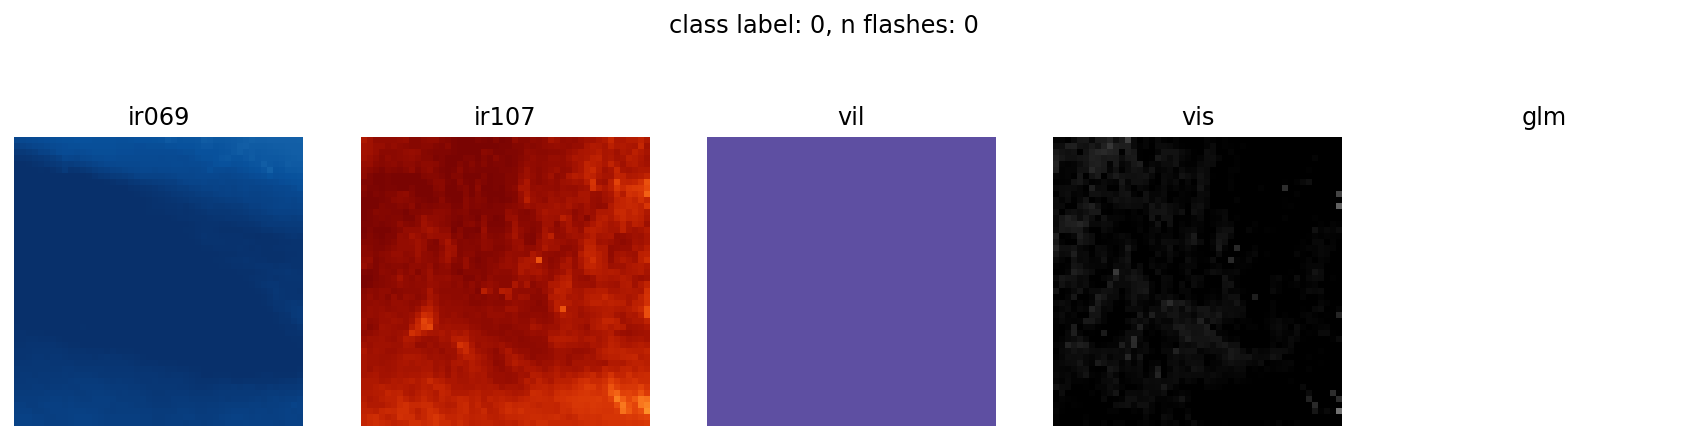

In [ ]:
#choose 1 'storm' to show in examples
ds_sample = ds_val.isel(n_samples=ds_val.groupby('id').groups['R19072715377489'])

show_sample(ds_sample.isel(n_samples=0))

#store this image to do the XAI on 
im = ds_sample.isel(n_samples=0).features.values 

Before we jump into the XAI, lets see the model predictions

In [ ]:
_,pred_class = model_class(im[np.newaxis,:,:,:])
_,pred_reg = model_reg(im[np.newaxis,:,:,:])
print('Classification output: {}'.format(str(np.round(tf.sigmoid(pred_class[0][0]),3))))
print('Regression output: {} flashes'.format(pred_reg[0][0]))

Classification output: 0.006
Regression output: 4.3690595626831055 flashes


For this example, there are some clouds on the visible imagery, but we can see these are warm (IR says warm for most of the image), implying that they are mainly shallow clouds, which are not capable of producing lightning. 

##### i. Classification

In [ ]:
# Construct the saliency object. This alone doesn't do anthing.
gradient_saliency = saliency.GradientSaliency()

# Compute the vanilla mask and the smoothed mask.
saliency_map = gradient_saliency.GetMask(im, call_model_function_class, call_model_args)
smooth_saliency = gradient_saliency.GetSmoothedMask(im, call_model_function_class, call_model_args,
                                                       nsamples=1000)

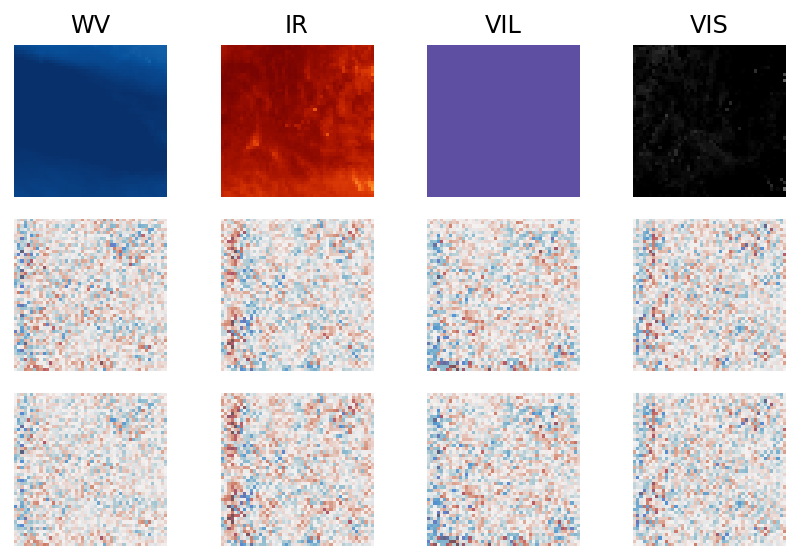

In [ ]:
#Plot the saliency 
ax,m = make_plot(im,mask=saliency_map)

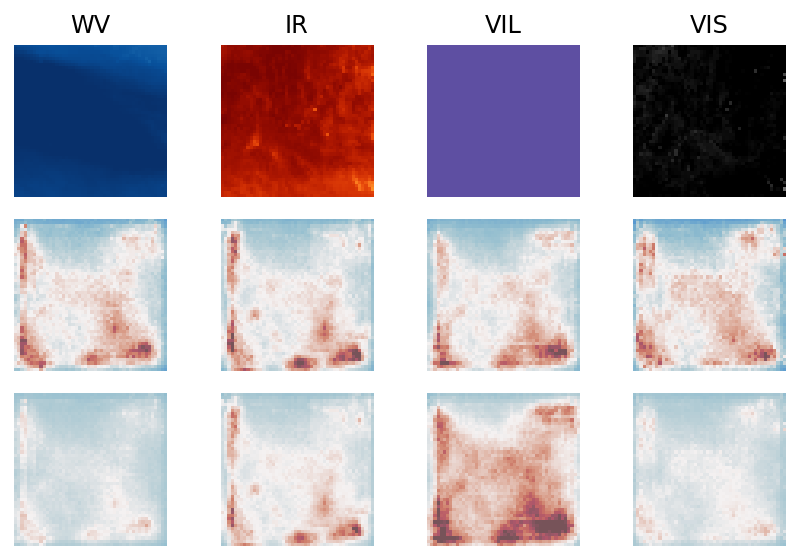

In [ ]:
#Plot the smooth saliency 
ax,m = make_plot(im,mask=smooth_saliency)

##### ii. Regression

In [ ]:
# Construct the saliency object. This alone doesn't do anthing.
gradient_saliency = saliency.GradientSaliency()

# Compute the vanilla mask and the smoothed mask.
saliency_map = gradient_saliency.GetMask(im, call_model_function_reg, call_model_args)
smooth_saliency = gradient_saliency.GetSmoothedMask(im, call_model_function_reg, call_model_args,
                                                       nsamples=1000)

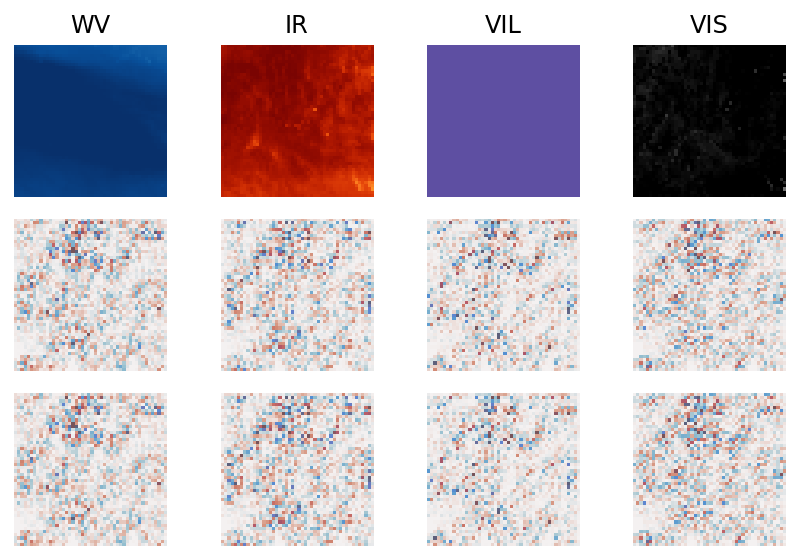

In [ ]:
#Plot the saliency 
ax,m = make_plot(im,mask=saliency_map)

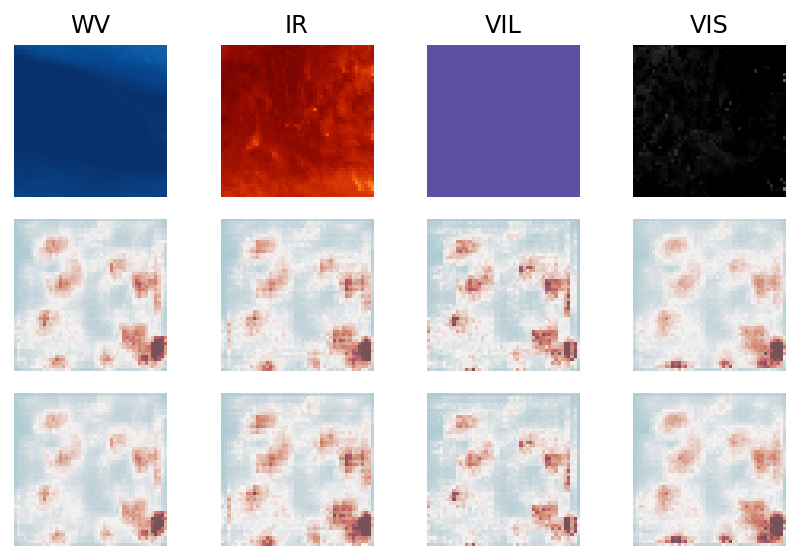

In [ ]:
#Plot the smooth saliency 
ax,m = make_plot(im,mask=smooth_saliency)

### 4). Inputs * Gradients

#### a. Strong Convection Example

/usr/local/lib/python3.7/dist-packages/xarray/core/computation.py:733: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


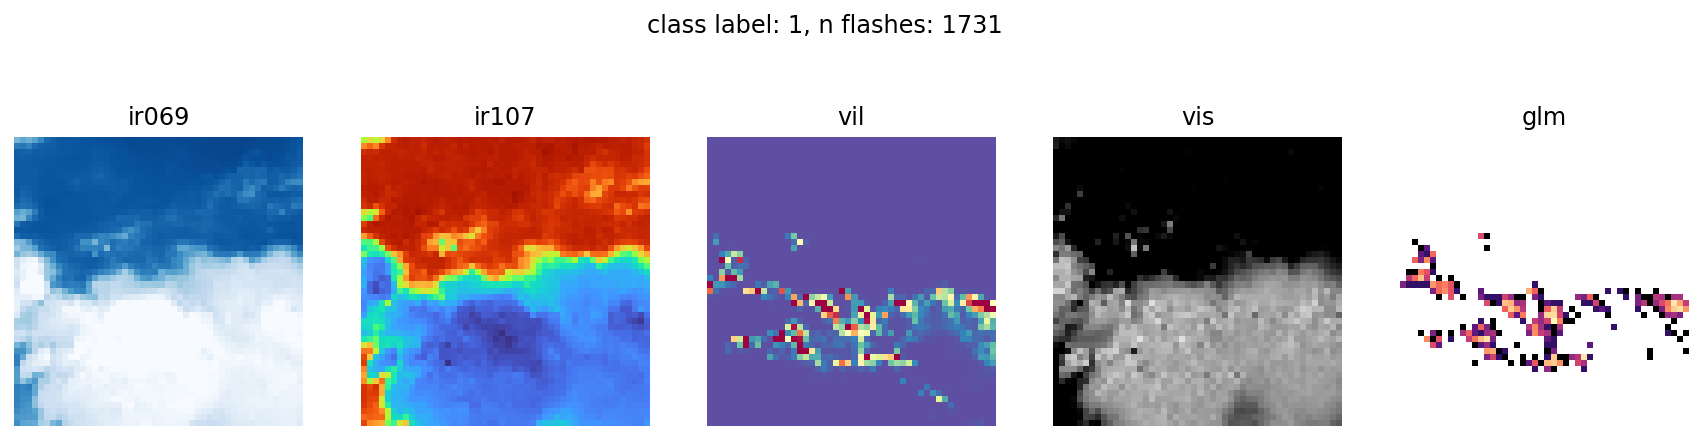

In [ ]:
#choose 1 'storm' to show in examples
ds_sample = ds_val.isel(n_samples=ds_val.groupby('id').groups['S841009'])

show_sample(ds_sample.isel(n_samples=11))

#store this image to do the XAI on 
im = ds_sample.isel(n_samples=11).features.values 

##### i. Classification

In [ ]:
# Construct the saliency object. This alone doesn't do anthing.
gradient_saliency = saliency.GradientSaliency()

# Compute the vanilla mask and the smoothed mask.
saliency_map = gradient_saliency.GetMask(im, call_model_function_class, call_model_args)
smooth_saliency = gradient_saliency.GetSmoothedMask(im, call_model_function_class, call_model_args,
                                                       nsamples=1000)

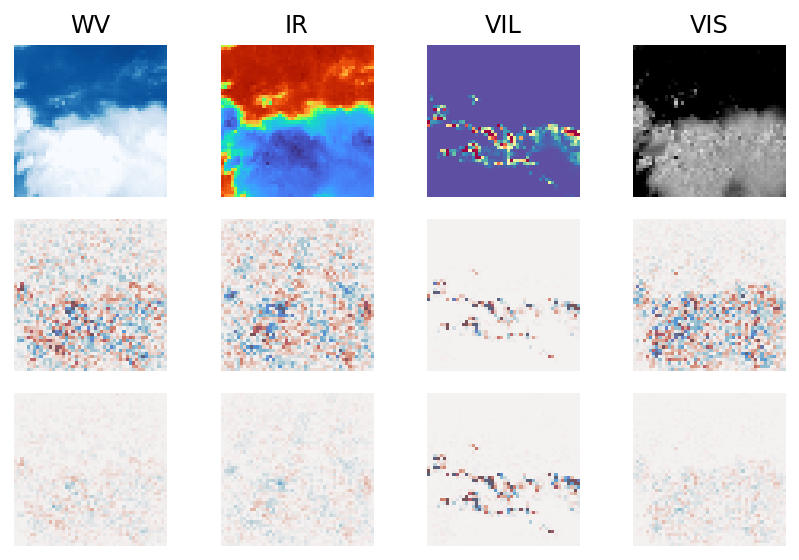

In [ ]:
#Plot the smooth saliency 
ax,m = make_plot(im,mask=im*saliency_map)

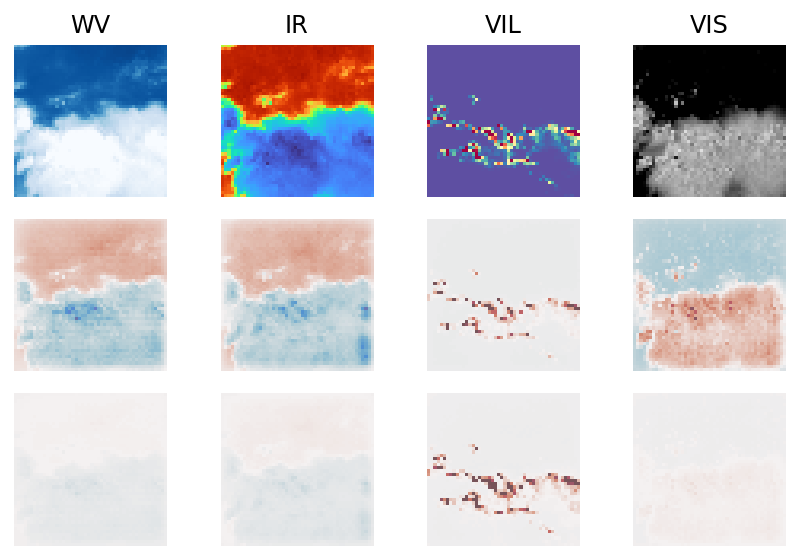

In [ ]:
#Plot the smooth saliency 
ax,m = make_plot(im,mask=im*smooth_saliency)

##### ii. Regression

In [ ]:
# Construct the saliency object. This alone doesn't do anthing.
gradient_saliency = saliency.GradientSaliency()

# Compute the vanilla mask and the smoothed mask.
saliency_map = gradient_saliency.GetMask(im, call_model_function_reg, call_model_args)
smooth_saliency = gradient_saliency.GetSmoothedMask(im, call_model_function_reg, call_model_args,
                                                       nsamples=1000)

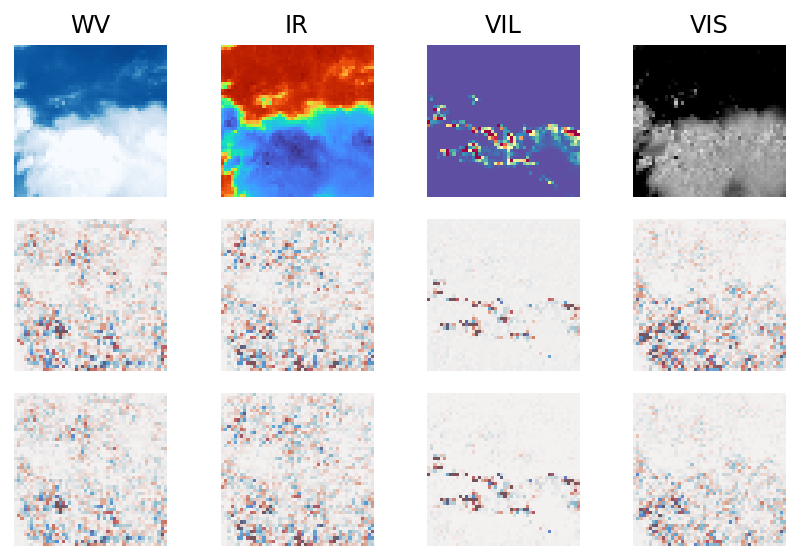

In [ ]:
#Plot the smooth saliency 
ax,m = make_plot(im,mask=im*saliency_map)

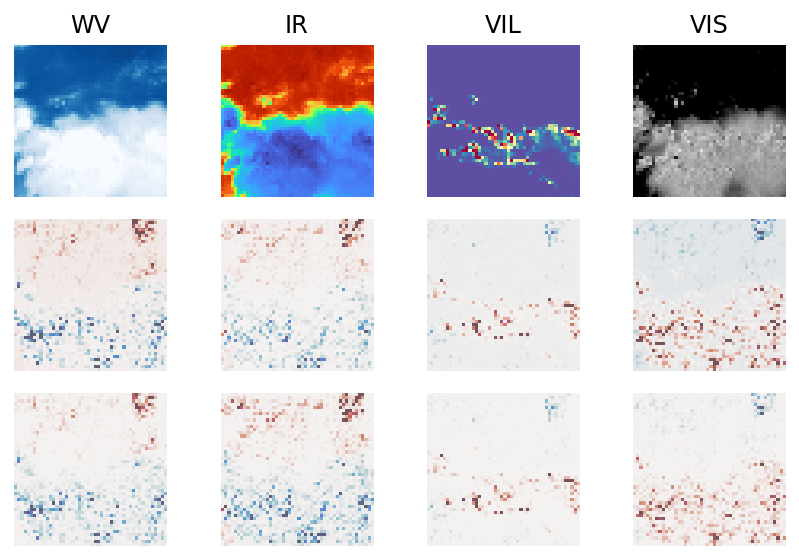

In [ ]:
#Plot the smooth saliency 
ax,m = make_plot(im,mask=im*smooth_saliency)

#### b. No Storm Example

/usr/local/lib/python3.7/dist-packages/xarray/core/computation.py:733: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)
/usr/local/lib/python3.7/dist-packages/matplotlib/image.py:452: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/usr/local/lib/python3.7/dist-packages/matplotlib/image.py:459: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/usr/local/lib/python3.7/dist-packages/matplotlib/image.py:464: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
<string>:6: UserWarning: Warning: converting a masked element to nan.
/usr/local/lib/python3.7/dist-packages/matplotlib/colors.py:993: UserWarning: Warning: converting a masked element to nan.
  data = np.asarray(value)


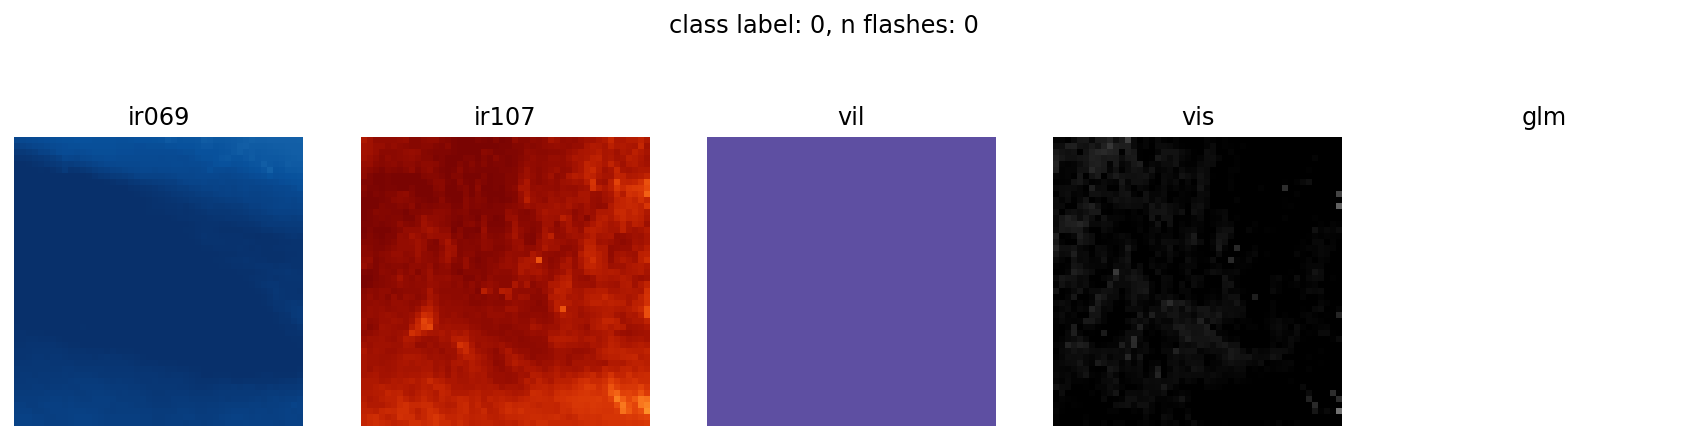

In [ ]:
#choose 1 'storm' to show in examples
ds_sample = ds_val.isel(n_samples=ds_val.groupby('id').groups['R19072715377489'])

show_sample(ds_sample.isel(n_samples=0))

#store this image to do the XAI on 
im = ds_sample.isel(n_samples=0).features.values 

##### i. Classification

In [ ]:
# Construct the saliency object. This alone doesn't do anthing.
gradient_saliency = saliency.GradientSaliency()

# Compute the vanilla mask and the smoothed mask.
saliency_map = gradient_saliency.GetMask(im, call_model_function_class, call_model_args)
smooth_saliency = gradient_saliency.GetSmoothedMask(im, call_model_function_class, call_model_args,
                                                       nsamples=1000)

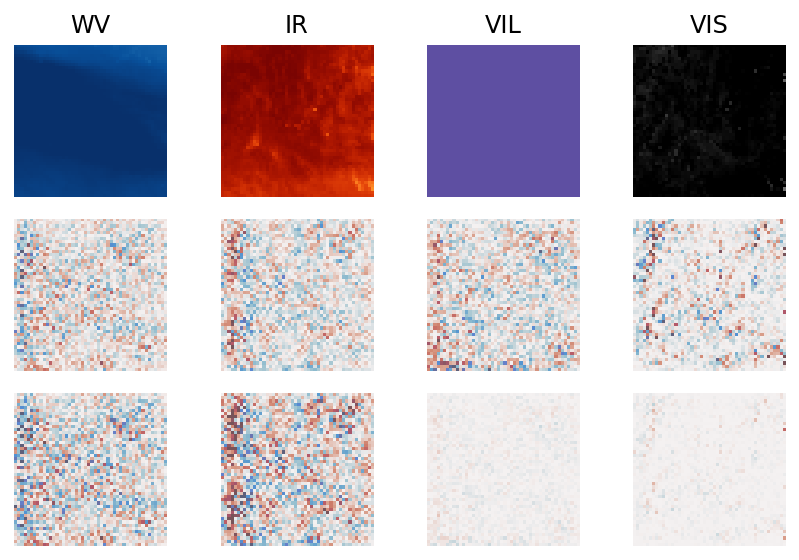

In [ ]:
#Plot the smooth saliency 
ax,m = make_plot(im,mask=im*saliency_map)

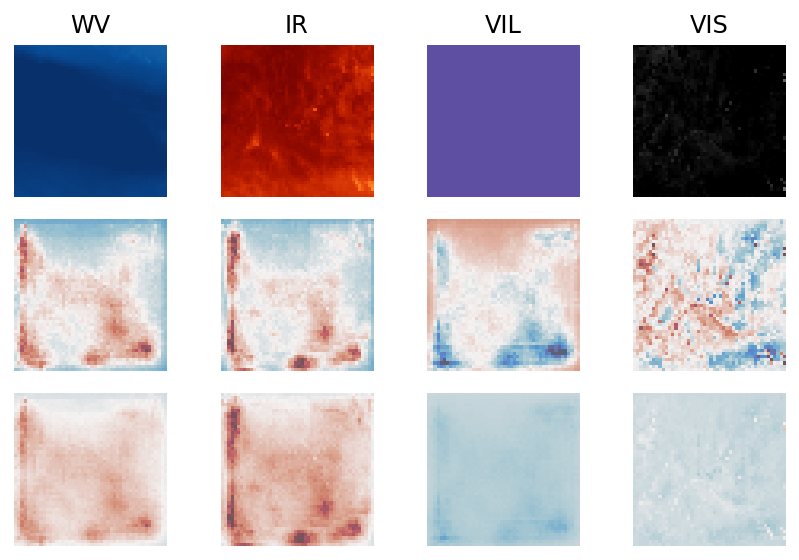

In [ ]:
#Plot the smooth saliency 
ax,m = make_plot(im,mask=im*smooth_saliency)

##### ii. Regression

In [ ]:
# Construct the saliency object. This alone doesn't do anthing.
gradient_saliency = saliency.GradientSaliency()

# Compute the vanilla mask and the smoothed mask.
saliency_map = gradient_saliency.GetMask(im, call_model_function_reg, call_model_args)
smooth_saliency = gradient_saliency.GetSmoothedMask(im, call_model_function_reg, call_model_args,
                                                       nsamples=1000)

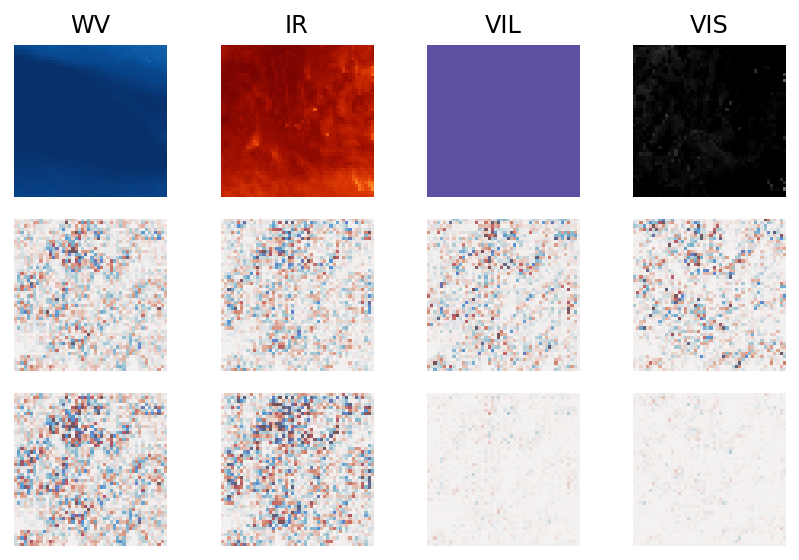

In [ ]:
#Plot the smooth saliency 
ax,m = make_plot(im,mask=im*saliency_map)

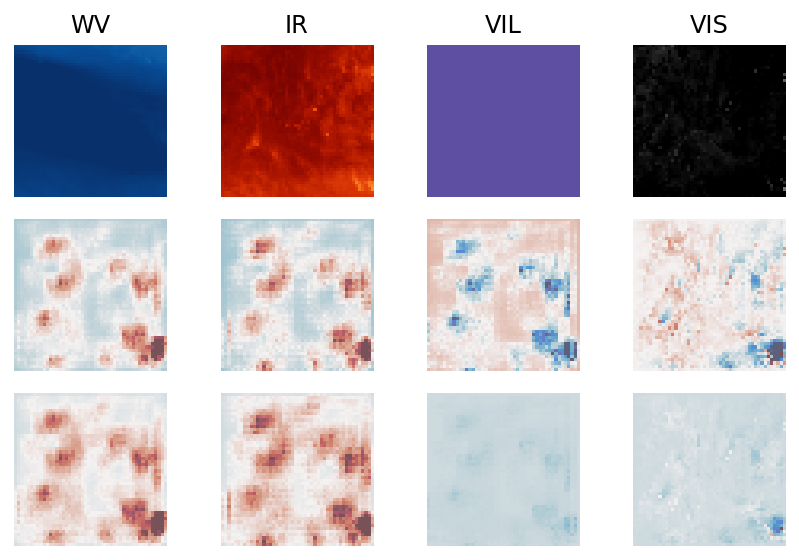

In [ ]:
#Plot the smooth saliency 
ax,m = make_plot(im,mask=im*smooth_saliency)

### 5). Summary

In this notebook we showed two case studies *explaining* the deep learning models predictions. One of them was a clear intense storm case with abundant lightning, the other was a cloudy event with no lightning.

### 6). How to select new cases

we only showed two examples above, but there are more than 100,000 images to look at in this dataset. To choose a new example you can look up new storms by index if you want. 

Below is an example of grabing image 42. 

/usr/local/lib/python3.7/dist-packages/xarray/core/computation.py:733: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


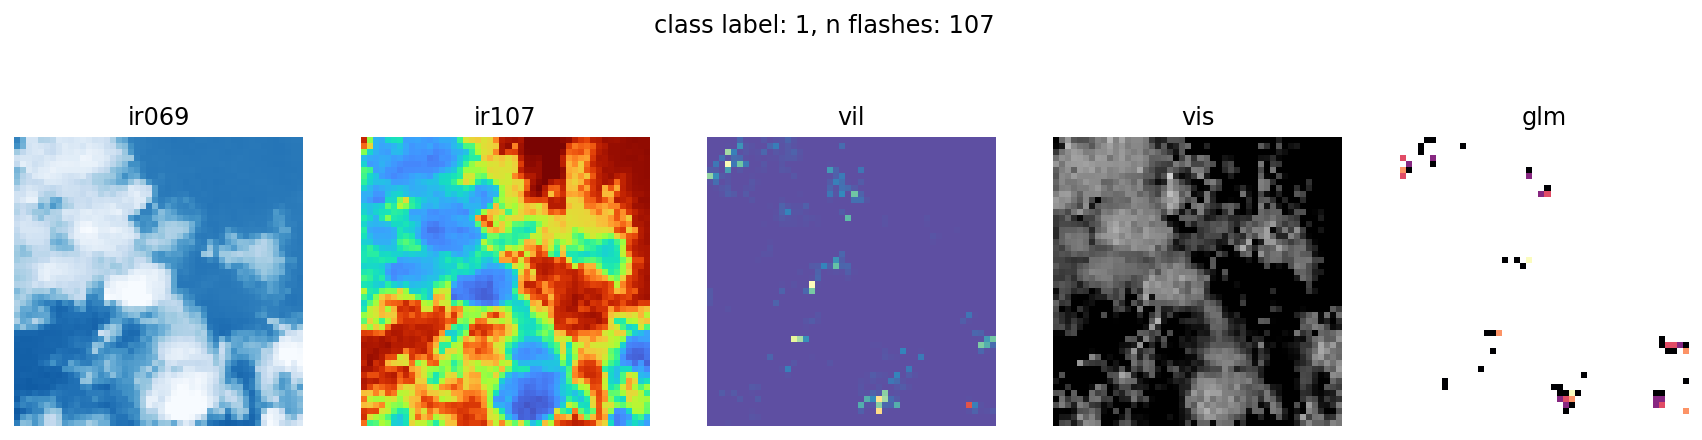

In [ ]:
#choose 1 'storm' to show in examples
ds_sample = ds_val.isel(n_samples=42)

#plot this example with a plotter function I have defined 
show_sample(ds_sample)

#store this image to do the XAI on 
im = ds_sample.features.values 

In [ ]:
_,pred_class = model_class(im[np.newaxis,:,:,:])
_,pred_reg = model_reg(im[np.newaxis,:,:,:])
print('Classification output: {}'.format(str(np.round(tf.sigmoid(pred_class[0][0]),3))))
print('Regression output: {} flashes'.format(pred_reg[0][0]))

Classification output: 0.997
Regression output: 90.090576171875 flashes


In [ ]:
# Construct the saliency object. This alone doesn't do anthing.
gradient_saliency = saliency.GradientSaliency()

# Compute the vanilla mask and the smoothed mask.
saliency_map = gradient_saliency.GetMask(im, call_model_function_class, call_model_args)
smooth_saliency = gradient_saliency.GetSmoothedMask(im, call_model_function_class, call_model_args,
                                                       nsamples=1000)

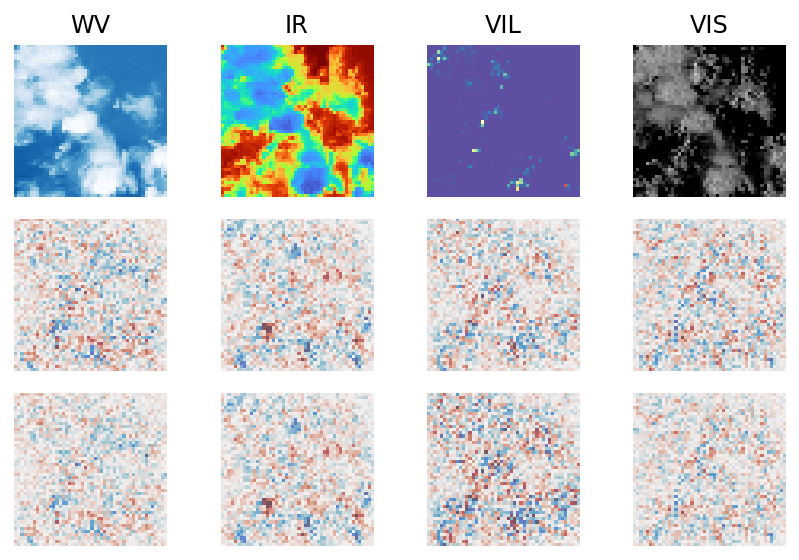

In [ ]:
#Plot the saliency 
ax,m = make_plot(im,mask=saliency_map)

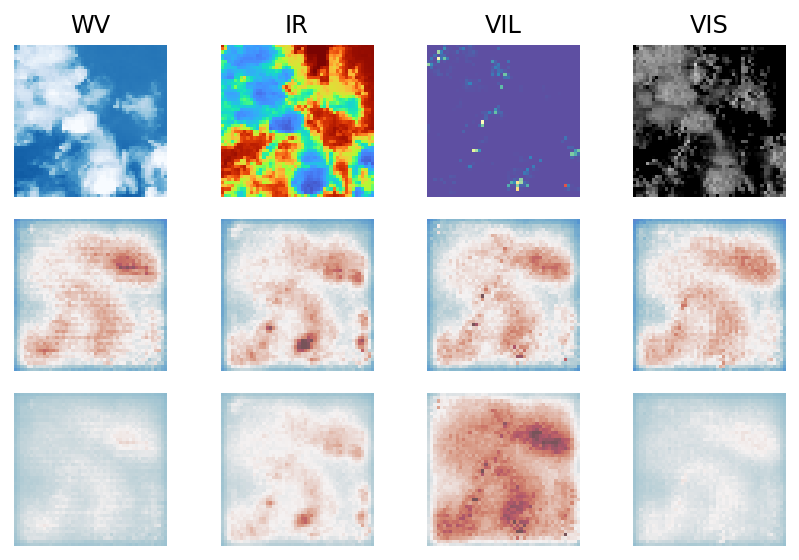

In [ ]:
#Plot the smooth saliency 
ax,m = make_plot(im,mask=smooth_saliency)

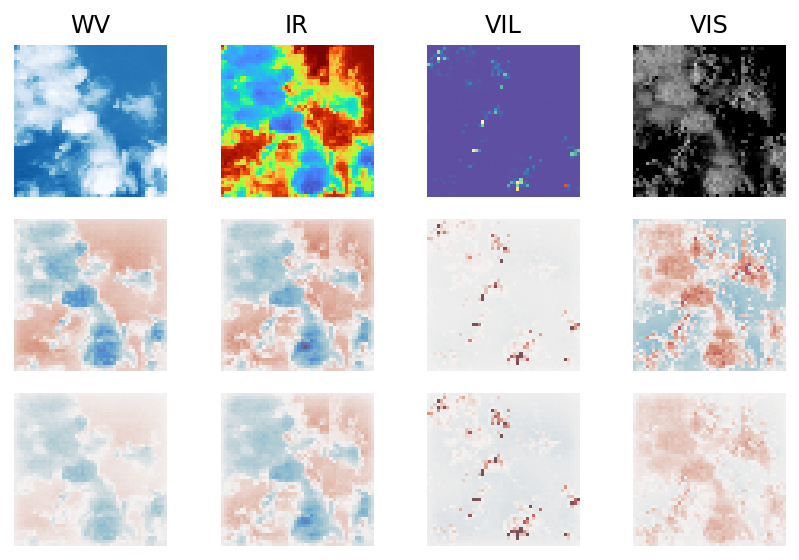

In [ ]:
#Plot the smooth saliency 
ax,m = make_plot(im,mask=im*smooth_saliency)

Then what if you wanted a different time step of this same 'storm system'

In [ ]:
#choose 1 'storm' to show in examples
ds_sample_all_time = ds_val.isel(n_samples=ds_val.groupby('id').groups[str(ds_sample.id.values)])

ds_sample_all_time

<xarray.Dataset>
Dimensions:         (n_samples: 12, x: 48, y: 48, n_channel: 4)
Coordinates:
    id              (n_samples) object 'R19072723347550' ... 'R19072723347550'
  * n_channel       (n_channel) <U5 'ir069' 'ir107' 'vil' 'vis'
  * n_samples       (n_samples) datetime64[ns] 2019-07-26T23:10:00 ... 2019-0...
Dimensions without coordinates: x, y
Data variables:
    features        (n_samples, x, y, n_channel) float32 ...
    label_1d_class  (n_samples) int8 ...
    label_1d_reg    (n_samples) int16 ...
    label_2d_class  (n_samples, x, y) int8 ...
    label_2d_reg    (n_samples, x, y) int16 ...

You can see now there is 12 samples, which are all the time steps of this one storm scene 

/usr/local/lib/python3.7/dist-packages/xarray/core/computation.py:733: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


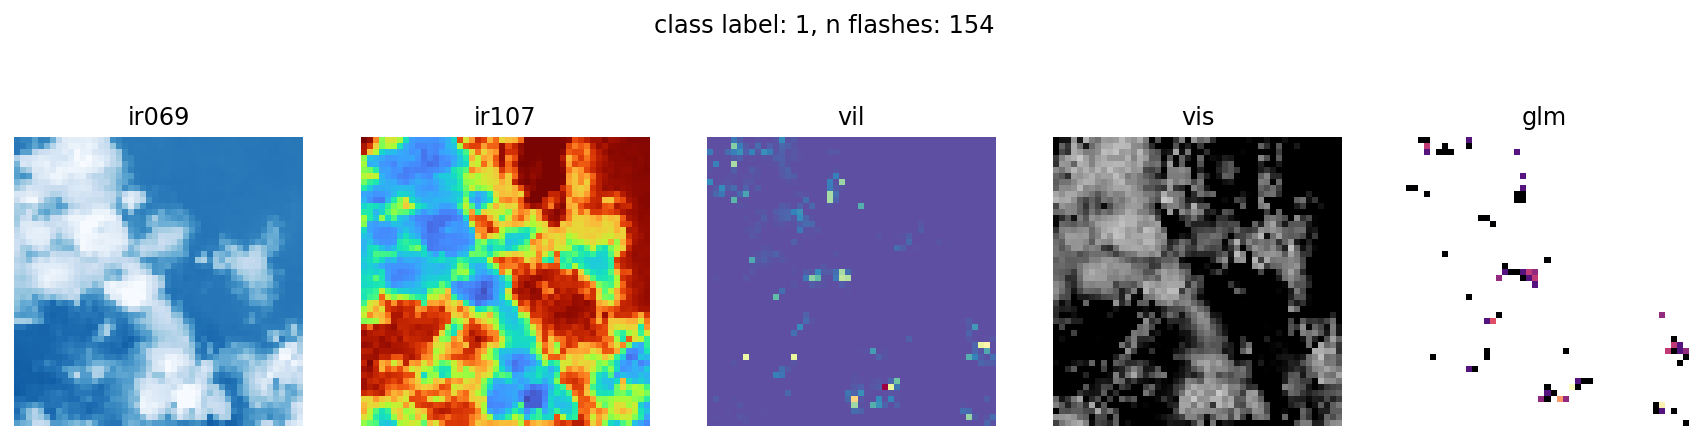

In [ ]:
#plot this example with a plotter function I have defined 
show_sample(ds_sample_all_time.isel(n_samples=0))

#store this image to do the XAI on 
im = ds_sample_all_time.isel(n_samples=0).features.values 